In [1]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [194]:
def create_target():
    target = pd.read_csv('data/SampleSubmissionStage1.csv').set_index('ID').drop('Pred', axis=1)
    target['Season'] = target.index.map(lambda i: i.split('_')[0])
    target['team_a'] = target.index.map(lambda i: i.split('_')[1])
    target['team_b'] = target.index.map(lambda i: i.split('_')[2])
    target['in_target'] = True
    
    ncaa_games = pd.read_csv('data/NCAATourneyCompactResults.csv')
    ncaa_games['team_a'] = ncaa_games[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) < int(t[1]) else t[1], axis=1)
    ncaa_games['team_b'] = ncaa_games[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) > int(t[1]) else t[1], axis=1)
    ncaa_games['a_win'] = ncaa_games['WTeamID'] == ncaa_games['team_a']
    ncaa_games['ID'] = ncaa_games['Season'].astype(str) + '_' + ncaa_games['team_a'].astype(str) + '_' + ncaa_games['team_b'].astype(str)
    ncaa_games = ncaa_games.set_index('ID')
    
    target = target.join(ncaa_games['a_win'], how='left')    
    return target

In [196]:
target = create_target()
print target.shape
target.head()

(9112, 5)


,Season,team_a,team_b,in_target,a_win
ID,,,,,
2014_1107_1110,2014,1107,1110,True,NaN
2014_1107_1112,2014,1107,1112,True,NaN
2014_1107_1113,2014,1107,1113,True,NaN
2014_1107_1124,2014,1107,1124,True,NaN
2014_1107_1140,2014,1107,1140,True,NaN


In [188]:
target_2.to_csv('data/target.csv')

In [65]:
ncaa_games = pd.read_csv('data/NCAATourneyCompactResults.csv')
ncaa_games = ncaa_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
ncaa_games['diff'] = ncaa_games['WScore'] - ncaa_games['LScore']
print(ncaa_games.shape)
ncaa_games.sample()

(2117, 9)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
1642,2010,145,1452,73,1246,66,N,0,7


In [66]:
regular_games = pd.read_csv('data/RegularSeasonCompactResults.csv')
regular_games = regular_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
regular_games['diff'] = regular_games['WScore'] - regular_games['LScore']
print(regular_games.shape)
regular_games.sample()

(150684, 9)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
149174,2017,98,1117,67,1157,57,H,0,10


In [67]:
data = cp.deepcopy(ncaa_games)
data['team_a'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) < int(t[1]) else t[1], axis=1)
data['team_b'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) > int(t[1]) else t[1], axis=1)
data['a_win'] = data['WTeamID'] == data['team_a']
data = data[['Season', 'team_a', 'team_b', 'a_win']]
data = pd.concat([data, target.reset_index(drop=True)]).fillna(0).astype({'a_win': bool, 'in_target': bool})

lags = 5
for team, opponent_team in [('a', 'b'), ('b','a')]:
    
    
    # GAMES WON IN PAST TOURNAMENTS
    won_in_ncaa = ncaa_games\
        .groupby(['WTeamID', 'Season']).count()[['diff']]\
        .rename(columns={'diff': 'won_in_ncaa_{}'.format(team)})
    for l in range(1, lags+1):
        won_in_ncaa[
            'won_in_ncaa_{}_lag-{}'.format(team, l)] = won_in_ncaa.groupby('WTeamID')[
            'won_in_ncaa_{}'.format(team)
        ].shift(l).fillna(0)
    won_in_ncaa.drop('won_in_ncaa_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, won_in_ncaa,
                    left_on=['team_{}'.format(team), 'Season'], right_index=True,
                    how='left').fillna(0)
    
    # GAMES WON IN PAST SEASONS
    won_in_season = regular_games\
        .groupby(['WTeamID', 'Season']).count()[['diff']]\
        .rename(columns={'diff': 'won_in_season_{}'.format(team)})
    for l in range(0, lags+1):
        won_in_season[
            'won_in_season_{}_lag-{}'.format(team, l)] = won_in_season.groupby('WTeamID')[
            'won_in_season_{}'.format(team)
        ].shift(l).fillna(0)
    won_in_season.drop('won_in_season_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, won_in_season,
                    left_on=['team_{}'.format(team), 'Season'], right_index=True,
                    how='left').fillna(0)
    
    
    # TOURNAMENT GAMES WON AGAINST OPPONENT
    ncaa_wins_against_opponent = ncaa_games\
        .groupby(['Season', 'WTeamID', 'LTeamID']).count()[['diff']]\
        .rename(columns={'diff': 'ncaa_wins_against_opponent_{}'.format(team)})
    for l in range(1, lags+1):
        ncaa_wins_against_opponent[
            'ncaa_wins_against_opponent_{}_lag-{}'.format(team, l)
        ] = ncaa_wins_against_opponent.groupby(['WTeamID', 'LTeamID'])\
            ['ncaa_wins_against_opponent_{}'.format(team)].shift(l)
    ncaa_wins_against_opponent.drop('ncaa_wins_against_opponent_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, ncaa_wins_against_opponent,
                    left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
                    right_index=True,
                    how='left').fillna(0)
    
    
    # SEASON GAMES WON AGAINST OPPONENT
    season_wins_against_opponent = regular_games\
        .groupby(['Season', 'WTeamID', 'LTeamID']).count()[['diff']]\
        .rename(columns={'diff': 'season_wins_against_opponent_{}'.format(team)})
    for l in range(0, lags+1):
        season_wins_against_opponent[
            'season_wins_against_opponent_{}_lag-{}'.format(team, l)
        ] = season_wins_against_opponent.groupby(['WTeamID', 'LTeamID'])\
            ['season_wins_against_opponent_{}'.format(team)].shift(l)
    season_wins_against_opponent.drop('season_wins_against_opponent_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, season_wins_against_opponent,
                    left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
                    right_index=True,
                    how='left').fillna(0)
    
    
data = data.dropna()
data.head(5)

,Season,a_win,in_target,team_a,team_b,won_in_ncaa_a_lag-1,won_in_ncaa_a_lag-2,won_in_ncaa_a_lag-3,won_in_ncaa_a_lag-4,won_in_ncaa_a_lag-5,...,ncaa_wins_against_opponent_b_lag-2,ncaa_wins_against_opponent_b_lag-3,ncaa_wins_against_opponent_b_lag-4,ncaa_wins_against_opponent_b_lag-5,season_wins_against_opponent_b_lag-0,season_wins_against_opponent_b_lag-1,season_wins_against_opponent_b_lag-2,season_wins_against_opponent_b_lag-3,season_wins_against_opponent_b_lag-4,season_wins_against_opponent_b_lag-5
0,1985,True,False,1116,1234,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1985,True,False,1120,1345,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1985,True,False,1207,1250,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1985,True,False,1229,1425,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1985,True,False,1242,1325,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
data.shape

(11229, 49)

In [69]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss


X = data[~data.in_target.astype(bool)].drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1)
y = data[~data.in_target.astype(bool)][['a_win']]

kf = KFold(n_splits=8, shuffle=True)
metrics = []
for tr_i, t_i in kf.split(X):
    X_tr, y_tr = X.iloc[tr_i], y.iloc[tr_i]
    X_t, y_t = X.iloc[t_i], y.iloc[t_i]
    xgb = XGBClassifier()
    xgb.fit(X_tr.values, y_tr.values.reshape(-1))
    preds = xgb.predict_proba(X_t.values)
    metric = log_loss(y_t.values, preds)
    print(metric)
    metrics.append(metric)
    
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))

0.36817660884545095
0.3783438413729013
0.41715384563431146
0.37670521427754244
0.3442789137609444
0.35916640002202865
0.34778091138595657
0.3729316670638086
Metric Mean: 0.37 (0.02)


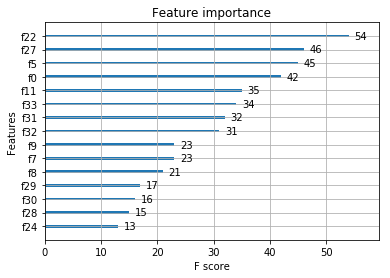

In [8]:
from xgboost import plot_importance

plt.figure(figsize=(20,4))
plot_importance(xgb, max_num_features=15)
plt.show()

In [11]:
data.head()

,Season,a_win,in_target,team_a,team_b,won_in_ncaa_a_lag-1,won_in_ncaa_a_lag-2,won_in_ncaa_a_lag-3,won_in_ncaa_a_lag-4,won_in_ncaa_a_lag-5,...,ncaa_wins_against_opponent_b_lag-2,ncaa_wins_against_opponent_b_lag-3,ncaa_wins_against_opponent_b_lag-4,ncaa_wins_against_opponent_b_lag-5,season_wins_against_opponent_b_lag-0,season_wins_against_opponent_b_lag-1,season_wins_against_opponent_b_lag-2,season_wins_against_opponent_b_lag-3,season_wins_against_opponent_b_lag-4,season_wins_against_opponent_b_lag-5
0,1985,True,False,1116,1234,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1985,True,False,1120,1345,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1985,True,False,1207,1250,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1985,True,False,1229,1425,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1985,True,False,1242,1325,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
X_sub = data[data.in_target.astype(bool)].drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1)
y_sub = data[data.in_target.astype(bool)][['Season', 'team_a', 'team_b', 'a_win', 'in_target']]

xgb = XGBClassifier()
xgb.fit(X.values, y.values.reshape(-1))
preds = xgb.predict_proba(X_sub.values)

sub = cp.deepcopy(y_sub)
sub['Pred'] = preds[:,1]
sub['ID'] = sub['Season'].map(str) + '_' + sub['team_a'].map(str) + '_' + sub['team_b'].map(str)
sub.set_index('ID', inplace=True)
sub.drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1, inplace=True)
sub.head()

,Pred
ID,
2014_1107_1110,0.611611
2014_1107_1112,0.021496
2014_1107_1113,0.874790
2014_1107_1124,0.069156
2014_1107_1140,0.900930


In [10]:
y_sub

,Season,team_a,team_b,a_win,in_target
0,2014,1107,1110,False,True
1,2014,1107,1112,False,True
2,2014,1107,1113,False,True
3,2014,1107,1124,False,True
4,2014,1107,1140,False,True
5,2014,1107,1142,False,True
6,2014,1107,1153,False,True
7,2014,1107,1157,False,True
8,2014,1107,1160,False,True
9,2014,1107,1163,False,True


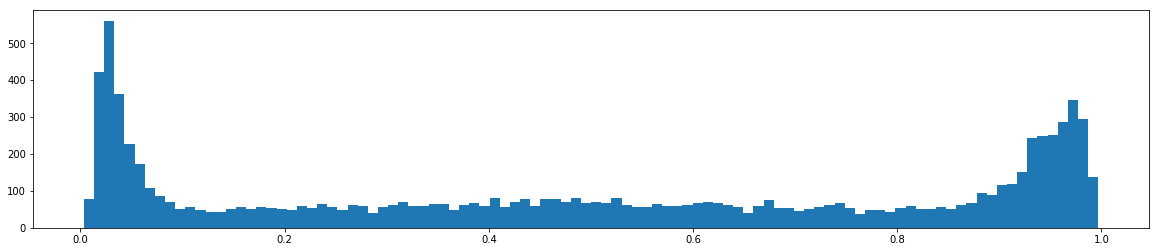

In [219]:
plt.figure(figsize=(20,4))
plt.hist(sub['Pred'], bins=100)
plt.show()

In [220]:
sub.to_csv('submissions/xgb_baseline_2_corrected_lags_and_features.csv')

In [12]:
### 

In [16]:
target = pd.read_csv('data/SampleSubmissionStage1.csv').set_index('ID').drop('Pred', axis=1)
target['Season'] = target.index.map(lambda i: i.split('_')[0])
target['team_a'] = target.index.map(lambda i: i.split('_')[1])
target['team_b'] = target.index.map(lambda i: i.split('_')[2])
target['in_target'] = True
target.head()

,Season,team_a,team_b,in_target
ID,,,,
2014_1107_1110,2014,1107,1110,True
2014_1107_1112,2014,1107,1112,True
2014_1107_1113,2014,1107,1113,True
2014_1107_1124,2014,1107,1124,True
2014_1107_1140,2014,1107,1140,True


In [23]:
ncaa_games = pd.read_csv('data/NCAATourneyCompactResults.csv')
ncaa_games['team_a'] = ncaa_games[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) < int(t[1]) else t[1], axis=1)
ncaa_games['team_b'] = ncaa_games[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) > int(t[1]) else t[1], axis=1)
ncaa_games['a_win'] = ncaa_games['WTeamID'] == ncaa_games['team_a']
ncaa_games['ID'] = ncaa_games['Season'].astype(str) + '_' + ncaa_games['team_a'].astype(str) + '_' + ncaa_games['team_b'].astype(str)
#ncaa_games = ncaa_games[['Season', 'team_a', 'team_b', 'a_win']]
#ncaa_games = pd.concat([ncaa_games, target.reset_index(drop=True)]).fillna(0).astype({'a_win': bool, 'in_target': bool})
ncaa_games = ncaa_games.set_index('ID')
ncaa_games.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,team_a,team_b,a_win
ID,,,,,,,,,,,
1985_1116_1234,1985,136,1116,63,1234,54,N,0,1116,1234,True
1985_1120_1345,1985,136,1120,59,1345,58,N,0,1120,1345,True
1985_1207_1250,1985,136,1207,68,1250,43,N,0,1207,1250,True
1985_1229_1425,1985,136,1229,58,1425,55,N,0,1229,1425,True
1985_1242_1325,1985,136,1242,49,1325,38,N,0,1242,1325,True


In [34]:
np.nansum()

131

In [39]:
submission = pd.read_csv('data/SampleSubmissionStage1.csv')
submission.head()

,ID,Pred
0,2014_1107_1110,0.5
1,2014_1107_1112,0.5
2,2014_1107_1113,0.5
3,2014_1107_1124,0.5
4,2014_1107_1140,0.5


In [41]:
target = target.join(ncaa_games['a_win']).drop('in_target', axis=1).dropna().sort_values(['Season', 'team_a', 'team_b'])

In [58]:
target['a_win'] = target['a_win'] * 1
target.to_csv('data/target.csv')

In [48]:
to_submit = pd.merge(submission, target.reset_index(), how='left', on='ID')
to_submit['Pred'] = to_submit['a_win']
to_submit = to_submit.fillna(0)[['ID', 'Pred']]
to_submit.head()

,ID,Pred
0,2014_1107_1110,0
1,2014_1107_1112,0
2,2014_1107_1113,0
3,2014_1107_1124,0
4,2014_1107_1140,0


In [55]:
(to_submit*1).to_csv('data/ground_truth_submission.csv', index=False)

In [197]:
## Features

In [2]:
from src.features.games import GameFeatures

In [3]:
game_features = GameFeatures()

In [6]:
game_features.season_games

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
0,1985,20,1228,81,1328,64,N,0,17
1,1985,25,1106,77,1354,70,H,0,7
2,1985,25,1112,63,1223,56,H,0,7
3,1985,25,1165,70,1432,54,H,0,16
4,1985,25,1192,86,1447,74,H,0,12
5,1985,25,1218,79,1337,78,H,0,1
6,1985,25,1228,64,1226,44,N,0,20
7,1985,25,1242,58,1268,56,N,0,2
8,1985,25,1260,98,1133,80,H,0,18
9,1985,25,1305,97,1424,89,H,0,8


## Neural net

In [115]:
from keras import Sequential
from keras.layers import Dense

In [119]:
train_data = data.loc[~data['in_target']]
train_data.head()

,Season,a_win,in_target,team_a,team_b,won_in_ncaa_a_lag-1,won_in_ncaa_a_lag-2,won_in_ncaa_a_lag-3,won_in_ncaa_a_lag-4,won_in_ncaa_a_lag-5,...,ncaa_wins_against_opponent_b_lag-2,ncaa_wins_against_opponent_b_lag-3,ncaa_wins_against_opponent_b_lag-4,ncaa_wins_against_opponent_b_lag-5,season_wins_against_opponent_b_lag-0,season_wins_against_opponent_b_lag-1,season_wins_against_opponent_b_lag-2,season_wins_against_opponent_b_lag-3,season_wins_against_opponent_b_lag-4,season_wins_against_opponent_b_lag-5
0,1985,True,False,1116,1234,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1985,True,False,1120,1345,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1985,True,False,1207,1250,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1985,True,False,1229,1425,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1985,True,False,1242,1325,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
print train_data['a_win'].shape
sum(train_data['a_win'])

(2117,)


1077

In [137]:
cols_to_drop = ['Season', 'a_win', 'in_target', 'team_a', 'team_b']

In [138]:
model = Sequential()
model.add(Dense(12, input_dim=data.shape[1]-len(cols_to_drop), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy'])

In [140]:
# Fit the model
model.fit(train_data.drop(cols_to_drop, axis=1), train_data['a_win']*1, epochs=10, batch_size=10)

Epoch 1/10
2117/2117 [==============================] - 1s 573us/step - loss: 0.8925 - binary_crossentropy: 0.8925
Epoch 2/10
2117/2117 [==============================] - 1s 250us/step - loss: 0.5894 - binary_crossentropy: 0.5894
Epoch 3/10
2117/2117 [==============================] - 1s 241us/step - loss: 0.5535 - binary_crossentropy: 0.5535
Epoch 4/10
2117/2117 [==============================] - 0s 228us/step - loss: 0.5376 - binary_crossentropy: 0.5376
Epoch 5/10
2117/2117 [==============================] - 0s 223us/step - loss: 0.5162 - binary_crossentropy: 0.5162
Epoch 6/10
2117/2117 [==============================] - 0s 225us/step - loss: 0.4996 - binary_crossentropy: 0.4996
Epoch 7/10
2117/2117 [==============================] - 0s 222us/step - loss: 0.5024 - binary_crossentropy: 0.5024
Epoch 8/10
2117/2117 [==============================] - 0s 223us/step - loss: 0.4845 - binary_crossentropy: 0.4845
Epoch 9/10
2117/2117 [==============================] - 0s 224us/step - loss: 0.

In [144]:
predictions = model.predict(train_data.drop(cols_to_drop, axis=1))

In [145]:
pd.Series(predictions.reshape(-1)).describe()

count    2117.000000
mean        0.498014
std         0.301187
min         0.003545
25%         0.213195
50%         0.509329
75%         0.777221
max         0.996799
dtype: float64

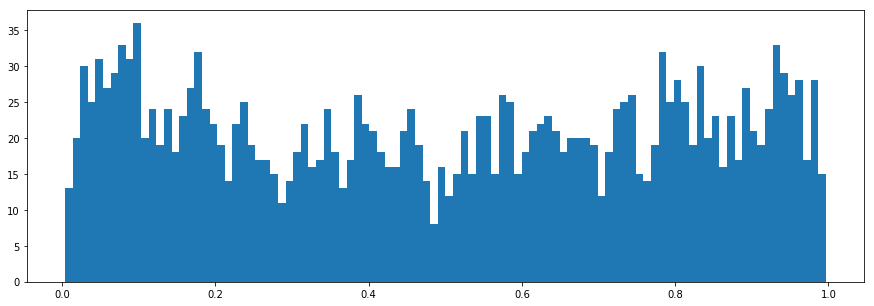

In [146]:
plt.figure(figsize=(15,5))
plt.hist(predictions, bins=100)
plt.show()

In [7]:
# evaluate the model
scores = model.evaluate(data.drop('a_win', axis=1), data['a_win'])

NameError: name 'model' is not defined

In [8]:
from src.models.nn.ann import ANN

In [9]:
ann = ANN(10, [10, 4, 5])

TypeError: unhashable type: 'list'